##### Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
from tqdm import tqdm

# Set pandas view options
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# filter warnings messages from the notebook
import warnings
warnings.filterwarnings('ignore')

from matminer.datasets.dataset_retrieval import load_dataset
## Generate magpie features
from matminer.featurizers.composition import ElementProperty
from pymatgen import Composition
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from pymatgen import MPRester, Composition
mpr = MPRester('68rWEneaZFyIaKh15uKr') # provide your API key here or add it to pymatgen

from camd.agent.base import RandomAgent, HypothesisAgent
from camd.analysis import AnalyzerBase
from camd.experiment import ATFSampler
from camd.campaigns.base import Campaign


##### Load matminer bandgap data

In [2]:
# load experimental dataset
data = load_dataset('expt_gap')

#clean up the dataframe, some weird formula
data = data[data.formula != 'GaAs0.1P0.9G1128']
data.head(2)

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08


##### Load MP theory bandgap data

In [3]:
# def get_MP_bandgap(formula):
#     """Given a composition, get the band gap energy of the ground-state structure
#     at that composition
    
#     Args:
#         composition (string) - formula
#     Returns:
#         (float) Band gap energy of the ground state structure"""
#     # The MPRester requires integer formuals as input
#     reduced_formula = Composition(formula).get_integer_formula_and_factor()[0]
#     struct_lst = mpr.get_data(reduced_formula)
    
#     # If there is a structure at this composition, return the band gap energy
#     if struct_lst:
#         return reduced_formula, sorted(struct_lst, key=lambda e: e['energy_per_atom'])[0]['band_gap']
#     else:
#         return reduced_formula, np.nan

# bandgap_info = {}
# formula_set = set(list(data['formula']))
# for formula in tqdm(list(formula_set)):
#     reduced_formula, bandgap = get_MP_bandgap(formula) 
#     bandgap_info[formula] = [reduced_formula, bandgap]   
# pickle.dump(bandgap_info, open('bandgap_by_formula.pkl', 'wb'))

In [5]:
bandgap_info = pickle.load(open('bandgap_by_formula.pkl', 'rb'))

##### Combine theory and experiment, and visualize

In [6]:
bandgap_df = pd.DataFrame([[key]+value for key, value in bandgap_info.items()], 
                          columns=['formula', 'reduced_formula', 'gap theory'])
final_df = pd.merge(data, bandgap_df, on='formula').drop(columns=['formula']).drop_duplicates()

##### Featurize Data - apply magpie elemental properties and a fixed cost ratio

In [7]:
final_df['cost_ratio'] = 10 # for now, experiment vs. DFT
final_df['composition'] = final_df['reduced_formula'].apply(Composition)
featurizer = ElementProperty.from_preset("magpie")
featurized_df = featurizer.featurize_dataframe(final_df, 'composition')

In [8]:
featurized_df.head(2)

,gap expt,reduced_formula,gap theory,cost_ratio,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData minimum NdUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData minimum NfUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData mode NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,0.35,Cd3Hg7Te10,NaN,10,"(Cd, Hg, Te)",48.0,80.0,32.0,61.2,13.16,52.0,70.0,90.0,20.0,80.35,9.65,90.0,112.411,200.59,88.179,150.86815,34.805295,127.6,234.32,722.66,488.

## Agent Design 

##### Benchmark with Random Agent & One-shot

In [9]:
class Analyzer(AnalyzerBase): 
    def __init__(self, target_bandgap, bandgap_range):
        self.num_discovered = [0]
        self.min_bandgap = target_bandgap - bandgap_range
        self.max_bandgap = target_bandgap + bandgap_range
        super(Analyzer, self).__init__()

    def analyze(self, experiments, seed_data):
        hits = experiments.loc[(experiments['gap expt']>=self.min_bandgap)&
                               (experiments['gap expt']<=self.max_bandgap)]

        self.num_discovered.append(self.num_discovered[-1]+hits.shape[0])
        new_seed = pd.concat([seed_data, experiments], axis=0)
        print(new_seed.shape[0])
        return [], new_seed

In [20]:
test_size = 0.2 # [0.2, 0.4, 0.6, 0.8]
iterations = 9

# split dataframe into seed and candidate
# some theory bandgap is np.nan, and CAMD drops those row during experiment
exp_df = featurized_df.drop(columns=['gap theory'], axis=1).copy() 
seed_df, candidate_df = train_test_split(exp_df, test_size=test_size)
N_query = int(candidate_df.shape[0]/(iterations+2))

In [21]:
# Random Agent
path = '/Users/ainipalizhati/Research/CAMD/scratches_AP/brgoch/'
random_agent = RandomAgent(candidate_data=candidate_df, n_query=N_query)
random_experiment = ATFSampler(dataframe=exp_df)
analyzer = Analyzer(target_bandgap=1.8, bandgap_range=0.2)

random_campaign = Campaign(candidate_data=candidate_df, seed_data=seed_df, 
                           agent=random_agent, experiment=random_experiment, 
                           analyzer=analyzer, path=path+'random')

In [22]:
random_campaign.auto_loop(n_iterations=iterations, initialize=True)

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
5055
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
5167
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
5279
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
5391
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 s

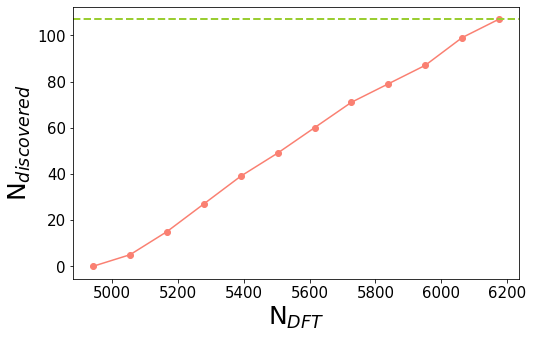

In [24]:
total_hits = candidate_df.loc[(candidate_df['gap expt']>=1.6)&(candidate_df['gap expt']<=2.0)].shape[0]
iterations_range = np.arange(0,iterations+3,1) 
total_seed = seed_df.shape[0] + N_query * iterations_range
discovered = analyzer.num_discovered

plt.figure(figsize=(8,5))
plt.plot(total_seed, discovered, 'o-', color='salmon')
plt.xlabel('N$_{DFT}$',fontsize=25)
plt.ylabel('N$_{discovered}$', fontsize=25)
plt.axhline(y=total_hits, color='yellowgreen', linestyle='--', lw=2)
plt.tick_params(axis="both", labelsize=15)
# plt.title('{} Seed_data Size'.format(round(1-test_size,2)), fontsize=30)
plt.show()